### Process the real (raw) Merian data
1. Scale the image to `ZP = 27.0` (same as HSC).
2. Subtract background. **TODO: Have to consider the effect of background subtraction on the weight map.**
3. Extract PSF at a given position
    
    Download and install `psfex`: https://github.com/esheldon/psfex

    Documentation: https://psfex.readthedocs.io/en/latest/GettingStarted.html

In [1]:
%load_ext autoreload
%autoreload 2

In [4]:
import numpy as np
import matplotlib.pyplot as plt

import astropy.units as u
from astropy import wcs
from astropy.io import fits
from astropy.table import Table, Column
from astropy.coordinates import SkyCoord
from astropy.visualization import make_lupton_rgb
from astropy.utils.data import download_file, clear_download_cache

import kuaizi
from kuaizi.display import display_single, SEG_CMAP
from kuaizi.download import download_decals_cutout
from kuaizi import DECaLS_pixel_scale, DECaLS_zeropoint

import pickle
from IPython.display import clear_output

In [5]:
import sep
from kuaizi.utils import save_to_fits

In [6]:
obj_cat = Table.read('/Users/jiaxuanli/Research/Merian/cosmos_test_1/cosmos_test_1-2021-02-04.fits')
obj = obj_cat[0]
obj

name,prefix,ra,dec,radius
,,,,arcsec
bytes18,bytes68,float64,float64,float64
s18a_wide_226984_y,/tigress/MERIAN/cutout/cosmos_test_1/1/226984/hsc/s18a_wide_226984_y,149.601282768496,1.6225202529022225,15.0


#### Image & Weight map

In [7]:
# Load Image
merian_hdu = fits.open('../merian_images/c4d_210307_021334_osj_N708_wide.fits.fz')
w_img = wcs.WCS(merian_hdu[1].header)
img = merian_hdu[1].data

In [8]:
print('ZP=', merian_hdu[0].header['MAGZERO'])

ZP= 30.677


In [9]:
img /= 10**(merian_hdu[0].header['MAGZERO'] - 27.0)  # scale to ZP = 27.0

In [10]:
bkg = sep.Background(img, bw=256, bh=256)

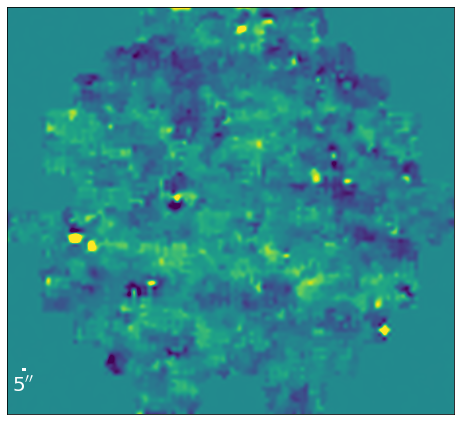

In [9]:
display_single(bkg.back());

In [23]:
# You can save background and bkg-subtracted image, if you like
# save_to_fits(bkg.back(), '../merian_images/merian_cosmos_bkg256.fits')
# save_to_fits(img - bkg.back(), '../merian_images/merian_cosmos_N708_bkgsub.fits', wcs=w_img)

In [11]:
# Load weight
weight_hdu = fits.open('../merian_images/c4d_210307_021334_osw_N708_wide.fits.fz')
weight = weight_hdu[1].data
w_weight = wcs.WCS(weight_hdu[1].header)

In [13]:
# Load PSF
import psfex
pex = psfex.PSFEx('../merian_images/cosmos_deep_init_backup.psf')

### Make cutouts

In [14]:
from kuaizi.utils import img_cutout
import os
filt = 'N708'

In [15]:
for obj in obj_cat[0:3]:
    obj_id = obj['name'].lstrip('s18a_wide').rstrip('_y')
    
    x, y = w_img.wcs_world2pix(obj['ra'], obj['dec'], 0)
    
    if not os.path.isdir(f'../cosmos_test_1/1/{obj_id}/merian/'):
        os.mkdir(f'../cosmos_test_1/1/{obj_id}/merian/')

    img_cut, [cen_pos, dx, dy], img_cut_header = img_cutout(
        (img - bkg.globalback), 
        w_img, obj['ra'], obj['dec'], # subtract a global bkg
        size=[obj['radius'] * 2, obj['radius'] * 2],
        pixel_scale=0.27,
        save=False,)
#     img_cele = Celestial(img_cut.data, header=img_cut_header, dataset='Merian',)
#     img_cele.resize_Celestial(0.272 / 0.168)
    
    weight_cut, [cen_pos, dx, dy], weight_cut_header = img_cutout(
        weight, w_weight, obj['ra'], obj['dec'],
        size=[obj['radius'] * 2, obj['radius'] * 2],
        pixel_scale=0.27,
        save=False,)
    
    psf_array = pex.get_rec(y, x)
    
    hdu1 = fits.HDUList([
        fits.PrimaryHDU(header=merian_hdu[0].header),  # header
        fits.ImageHDU(data=img_cut.data, header=img_cut_header,
                      name='IMAGE'),  # image
        fits.ImageHDU(data=None, header=None,
                      name='MASK'),  # mask, here mask is none
        fits.ImageHDU(
            data=weight_cut.data, header=weight_cut_header,
            name='WEIGHT'),  # weight
        fits.ImageHDU(
            data=psf_array,
            name='PSF'),  # PSF
    ])
        
#     hdu1 = fits.HDUList([
#         fits.PrimaryHDU(header=merian_hdu[0].header),  # header
#         fits.ImageHDU(data=img_cut.data, header=img_cut_header,
#                       name='IMAGE'),  # image
#         fits.ImageHDU(data=None, header=None,
#                       name='MASK'),  # mask, here mask is none
#         fits.ImageHDU(
#             data=weight_cut.data, header=weight_cut_header,
#             name='WEIGHT'),  # weight
#     ])
    fits_file = f'merian_{obj_id}_{filt}' + '.fits'
    fits_file = os.path.join(f'../cosmos_test_1/1/{obj_id}/merian/', fits_file)

    hdu1.writeto(fits_file, overwrite=True)

In [16]:
fits_file

'../cosmos_test_1/1/238189/merian/merian_238189_N708.fits'